#Initiate

##Requirements 

In [1]:
!pip install stable-baselines==2.10.2
!pip install pymoo==0.4.2.2

%tensorflow_version 1.x

import gym
import numpy as np
from stable_baselines import DQN
from copy import deepcopy
import math
from gym.spaces import Discrete, Dict, Box
from gym import spaces
from random import seed
import random 
from gym import Env
from datetime import datetime
import sys
import time
import pickle
import stable_baselines
import sklearn
import numpy
from sklearn import tree , svm 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.utils import resample
from sklearn.model_selection import KFold , RepeatedKFold
from sklearn.metrics import f1_score
from sklearn import impute
import statistics
from scipy import stats
from copy import deepcopy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from math import ceil
import copy
import sys
from sklearn.metrics import jaccard_score
import time
import multiprocessing
from pymoo.algorithms.nsga2 import calc_crowding_distance
sys.path.append('lib/')
import subprocess
import logging
from sklearn.utils import shuffle
import csv
from csv import reader
import os
import statistics

     |████████████████████████████████| 240 kB 3.8 MB/s 
     |████████████████████████████████| 3.7 MB 4.4 MB/s 
     |████████████████████████████████| 239 kB 45.5 MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4940018 sha256=18f1f4bae63382de9a4757a88079fd441fc17eb4c1a23caa5ea79e59e7b0d2cf
  Stored in directory: /root/.cache/pip/wheels/ab/8c/89/c450ad360fc24cb70fec0388e8d95b51021eae5dab248ab76e
Successfully built pymoo
TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
!pip install ipython-autotime

%load_ext autotime

time: 159 µs (started: 2022-05-13 16:24:11 +00:00)


##RL

In [3]:
class StoreWrapper(gym.Wrapper):
  ''''
  :param env: (gym.Env) Gym environment that will be wrapped
  :param max_steps: (int) Max number of steps per episode
  '''
  def __init__(self, env):
    # Call the parent constructor, so we can access self.env later
    super(StoreWrapper, self).__init__(env)
    self.max_steps = 200
    # Counter of steps per episode
    self.current_step = 0
    self.mem = []
    self.TotalReward = 0.0 
    self.env = env
    self.first_state = 0
    self.first_obs = 0
    self.prev_obs = 0 
    self.states_list = []
  
  def reset(self):
    """
    Reset the environment 
    """
    # Reset the counter
    self.current_step = 0
    obs =self.env.reset()
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

  def step(self, action):
    """
    In this function we store the initial state as well as the memory of the agent
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    if self.current_step == 0: #store initial state
      self.prev_obs = self.first_obs
      self.first_state = deepcopy(self.env)
      self.states_list.append(self.first_state)
    self.current_step += 1
    obs, reward, done, info = self.env.step(action)
    self.TotalReward += reward
    self.mem.append(tuple((self.prev_obs,action)))
    self.prev_obs = obs
    if self.current_step >= self.max_steps:
      done = True
      # Update the info dict to signal that the limit was exceeded
    if done:
      self.mem.append(tuple(('done',self.TotalReward)))
    info['mem'] = self.mem
    info['state'] = self.states_list
    # self.mem.append(tuple(obs,action))
    return obs, reward, done, info

  def set_state(self, state):
    """
    :param state: initial state of the episode
    :return: environment is updated and observations is returned
    """
    self.env = deepcopy(state)
    obs = np.array(list(self.env.unwrapped.state))
    self.current_step = 0
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

def proportional_sampling_whitout_replacement(index , size):
  s=0
  s = sum(np.array(index))
  p = [ind/s for ind in index]
  samples = np.random.choice(index,size=size,replace=False,p=p)
  return samples

def population_sample(episodes , ind,  pop_size , random_test_size, threshold, functional_fault_size, reward_fault_size):
  """
  This function is meant to sample episodes from training after that you need to add test episodes using random_test 
  Set the parameters as you want but be careful the input episodes for this function is the memory of the agent and each step has seperate index 
  this function returs the final steps of the selected function then you need to extract that episodes from the input memore that is called 'episodes'
  use the episodes extract function ... 

  samples n episodes from training n1 functinal faults and n2 reward faults 
  reward faults are episodes with reward bellow the thresthreshold 
  from random test samples M episodes m1 random episode and
  m2 episodes with sudden reward change we dont have a sudden reward change in this example  
  """
  epsilon = 0.05
  index = []
  functional_fault = []
  reward_fault = []
  start_states =[]
  ind  = np.where(np.array(episodes)==('done',))
  index= ind[0]
  print(len(ind[0]),'episodes from training')
  population=[]
  for i in index:
    _,r = episodes[i]
    if abs(episodes[i-1][0][0])>(2.4-epsilon):
      functional_fault.append(i)
      print('function fault') 
    if r<threshold:
      reward_fault.append(i)
      print('reward fault')
  if len(functional_fault)<functional_fault_size:
    print('functional faults size is' ,len(functional_fault),' and its less than desired number' )
    population += functional_fault
    print('sampling more random episodes instead ...!')
  if len(functional_fault)==functional_fault_size:
    population += functional_fault
  if len(functional_fault)>functional_fault_size:
    # proportianl_sample_whitout_replacement()
    sam1=proportional_sampling_whitout_replacement(functional_fault,functional_fault_size)
    population += sam1
  if len(reward_fault)<reward_fault_size:
    print('reward faults size is' ,len(reward_fault),' and its less than desired number' )
    population += reward_fault
    print('sampling more random episodes instead ...!')
  if len(reward_fault)==reward_fault_size:
    population += reward_fault
  if len(reward_fault)>reward_fault_size:
    #proportional sampling
    sam2 = proportional_sampling_whitout_replacement(reward_fault,reward_fault_size)
    population += list(sam2)
  r_size= pop_size-len(population)
  # random_test(model,env,r_size)
  print(len(reward_fault))
  # population += reward_fault
  return population , r_size


def episode_extract(sampled_index, episodes):
  epis = []
  for i in sampled_index:
    l=int(episodes[i][1])
    slice1 = episodes[(i-l):(i+1)]
    epis+=slice1
  return epis


def fitness_reward(episode):
  """
  here the reward could be calculated as the lengh of the episode; Since the
  reward of the cartpole is defined based on the number of steps without falling
  last part of the episode contains the signal of ('done',reward)
  """
  return len(episode)-1

def fitness_confidence(episode, model, mode):
  """
  confidence level is define as differences between the highest and
  second highest action probabilities of selecting actions OR
  the ratio between the highest and lowest/second highest action probability
  :param `mode`: r for ration and m for differences 
  :param `model`: is the RL agent 
  :param `episode`: is the episode values or sequence from the rl 
  """
  cl = 0.0
  for i in range(len(episode)):
    if i==(len(episode)-1):
        if episode[i][0]=='done':
            return (cl/episode[i][1])
        else:
            assert False, "last state is not done , reward"
    else:
      prob=model.action_probability(episode[i][0])
      high1=prob.argmax()
      first = prob[high1]
      temp = prob
      temp[high1] = 0.0
      high2= temp.argmax()
      second = prob[high2]
      if mode == 'r':
        cl +=  (first/second)
        #In the next version this will be updated to a normalized ratio to avoid having large values 
      if mode == 'm':
        cl += (first - second) #To_Do: first - second / first +second this one is better 
  print("WARNING nothing returned", episode )


def fitness_reward_probability(ml, binary_episode):
  """
  This function returns the third fitness funciton that is ment to guide the search toward
  the episodes with a higher probability of a reward fault and as we have a minimizing 
  optimization funciton in MOSA we neeed to change this functionwe can either go with the
  negation of the probability of the reward fault = 1-probability of the reward fault
  that is equal to the probability of the bein a non-faulty episode
  :param `ml`: RF_FF_1rep for functional fault
  :param `binary episode`: episodes decodeed as having abstract states
  """
  # return -(ml.predict_proba(episode)[0][1])
  return ml.predict_proba(binary_episode)[0][0]

def fitness_functional_probability(ml, binary_episode):
  return ml.predict_proba(binary_episode)[0][0]


def state_abstraction(model,state1,state2,d):
  """
  This function compares to state, if they were in the same abstract class
  function returs 'True' otherwise 'False'
  """
  q_value1 = model.step_model.step([state1])
  q_value2 = model.step_model.step([state2])
  for i in range(len(q_value1[1][0])):
    print(q_value1[1][0][i])
    print(q_value2[1][0][i])
    if ceil(q_value1[1][0][i]/d) == ceil(q_value2[1][0][i]/d):
     continue
    else:
      return False
  return True


def abstract_state(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_value1 = model.step_model.step([state1])
  return( ceil(q_value1[1][0][0]/d), ceil(q_value1[1][0][1]/d))


#report function to check the performance metrics of the model
def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test)
  metrics.plot_roc_curve(model2, x_test, y_test) 
  plt.show()

#dump

def dump_p(what, name):
  with open(f'/content/drive/MyDrive/Data/{name}.pickle', 'wb') as file:
      pickle.dump(what, file)


# write function for load

def load_p(to_what, name):
  with open(f'/content/drive/MyDrive/Data/{name}.pickle', 'rb') as file2:
    to_what = pickle.load(file2)


def random_test_1(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    # env.render()
    episode_reward += reward
    if done:
      counter += 1
      end = i
      print("Reward:", episode_reward, "final state", info['mem'][-2][0])
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = info['mem'][lastpoint:-fin]
  ran_state = info['state'][(-counter+1):-1]
  return randomtest , ran_state


def fix_training(training_episodes,training_states):
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(training_episodes)):
    if training_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(training_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(training_episodes[i])
  if len(episodes_set)!=len(training_states):
    del training_states[-1]
  if len(episodes_set)!=len(training_states):
    # assert False, 'problem in starting states'
    print('problem in starting states')
  return episodes_set , training_states

def fix_testing(testing_episodes,testing_states,Env2):
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(testing_episodes)):
    if testing_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(testing_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(testing_episodes[i])
  if not (episodes_set[0][0][0]==Env2.set_state(testing_states[0])).all():
    del testing_states[0]
  if not (episodes_set[0][0][0]==Env2.set_state(testing_states[0])).all():
    assert False, 'problem in starting states'
  if len(episodes_set)!=len(testing_states):
    del testing_states[-1]
  if len(episodes_set)!=len(testing_states):
    assert False, 'problem in data prepration'
  return episodes_set , testing_states


time: 1 s (started: 2022-05-13 16:24:11 +00:00)


##ML

In [4]:
def Abstract_classes(ep,abstraction_d,model):
  d=abstraction_d
  abs_states1=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state(model,state,d)
      if abs_st == 'end':
        continue
      abs_states1.append(abs_st)
  unique1=list(set(abs_states1))
  uni1 = np.array(unique1)
  a=len(abs_states1)
  b=len(set(abs_states1))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique1,uni1


def ML_first_representation(Abs_d,epsilon_functional_fault_boarder,uni1,model,ep,unique1):
  d = Abs_d
  # epsilon = 0.05
  epsilon = epsilon_functional_fault_boarder
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  functional_fault = False
  reward_fault_threshold = 70
  for episode in ep:
    record = np.zeros(len(uni1))
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        # print(action)
        if functional_fault:
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if action >= reward_fault_threshold:
          data1_y_b.append(0)
        else:
          data1_y_b.append(1)
        functional_fault=False
        continue
      if abs(state[0]) >= (2.4-epsilon) :
        functional_fault = True
      ind = unique1.index(ab)
      # if len(w[0])>1:
        # print('error len is greater than 1')
      record[ind] = 1
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

time: 41.3 ms (started: 2022-05-13 16:24:12 +00:00)


##Genetic

In [5]:
def translator(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  d=d
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
    record[ind] = 1
  return [record]

def transform(state):
  position = state[0]
  noise = np.random.uniform(low=0.95, high=1.05)
  new_position= position * noise 
  new_state =deepcopy(state)
  new_state[0] = new_position 
  #if new_position>2.4:
  # newstate = 2.4
  #if new_position<-2.4:
  # newstate = -2.4
  return new_state


def mutation_improved(population,model,env,objective_uncovered):
  """
  This is the final mutation function 
  It takes the population as input and returns the mutated individual
  :param 'population': Population that we want to mutate 
  :param 'model': RL model
  :param 'env': RL environment
  :param 'objective_uncovered: uncovered ubjectives for tournament selection
  :return: mutated candidate (we re-rexecute the episode from the mutation part)
  To-do:
  move deepcopy to the cadidate class methods .set info 
  """
  parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
  parent1 = deepcopy(parent.get_candidate_values())
  if len(parent1) < 3:
     assert False , "parent in mutation is shorter than 3"
  Mutpoint = random.randint(3,(len(parent1)-3))
  new_state = transform(parent1[Mutpoint][0])
  action = model.predict(new_state)
  if action[0]!= int(parent1[Mutpoint][1]):
    print('Mutation lured the agent ... ')
  new_parent = parent1[:Mutpoint]
  new_parent.append([new_state,'Mut'])
  new_cand =Candidate(new_parent)
  new_cand.set_start_state(parent.get_start_state())

  re_executed_epis = re_execute(model,env,new_cand)
  
  re_executed_cand = Candidate(re_executed_epis)
  re_executed_cand.set_start_state(new_cand.get_start_state())
  re_executed_cand.set_info(deepcopy(parent.get_info()))
  re_executed_cand.set_info(["mutation is done! ", "mutpoint was:",Mutpoint])

  
  return re_executed_cand

def mutation_improved_p(parent,model,env,m_rate):
  """
  This is the final mutation function with input of a parent considering internal m_rate
  Here we give the parent to themutation funcion based on the given mutation 
  rate of m_rate, we may mutate the episodes. 
  :param 'parent' : individual that we want to mutate
  :param 'model': RL model
  :param 'env': RL environment
  :param 'm_rate': mutation : recommended value is 1/len(parent)
  :return : mutated individual
  To-do:
  move deepcopy to the cadidate .set info 
  """
  # parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
  global MUTATION_NUMBER
  chance = random.uniform(0, 1)
  if chance> m_rate:
    return parent
  else:
    parent1 = deepcopy(parent.get_candidate_values())
    if len(parent1) < 3:
      assert False , "parent in mutation is shorter than 3"
    Mutpoint = random.randint(3,(len(parent1)-3))
    new_state = transform(parent1[Mutpoint][0])
    action = model.predict(new_state)
    if action[0]!= int(parent1[Mutpoint][1]):
      print('Mutation lured the agent ... ')
    new_parent = parent1[:Mutpoint]
    new_parent.append([new_state,'Mut'])
    new_cand =Candidate(new_parent)
    new_cand.set_start_state(parent.get_start_state())
    re_executed_epis = re_execute(model,env,new_cand)
    re_executed_cand = Candidate(re_executed_epis)
    re_executed_cand.set_start_state(new_cand.get_start_state())
    re_executed_cand.set_info(deepcopy(parent.get_info()))
    re_executed_cand.set_info(["mutation is done! ", "mutpoint was:",Mutpoint])
    MUTATION_NUMBER+=1
    return re_executed_cand




def Crossover_improved_v2(population,model,d,objective_uncovered):
  """
  This is the crossover function that we are using 
  It takes the population as input and returns the mutated individual
  :param 'population': Population. we select a parent based on the tournament
   selection and then select the mutation point and then search for the matching point. 
  :param 'model': RL model
  :param 'env': RL environment
  :param 'objective_uncovered: uncovered ubjectives for tournament selection
  :return: mutated candidate (we re-rexecute the episode from the mutation part)
  To-do:
  finding matching episode could be improved bu storing a mapping between concrete states and  
  """
  found_match = False 
  while not (found_match):
    parent = tournament_selection(population, 10, objective_uncovered)  # tournament selection
    parent1 = deepcopy(parent.get_candidate_values())
    parent1_start_point = deepcopy(parent.get_start_state())
    if len(parent1)<4:
      assert False, 'input of crossover is shorter than expected '
    matches_list = []
    crosspoint = random.randint(1,(len(parent1)-3))
    abs_class = list(abstract_state(model,parent1[crosspoint][0],d))
    for i in range(50):
      indx = random.randint(0, len(population) - 1)
      random_candidate = deepcopy(population[indx])
      random_cand_data = random_candidate.get_candidate_values()
      random_cand_start_point = random_candidate.get_start_state()
      for st_index in range(1,len(random_cand_data)-3):
        random_ab = list(abstract_state(model,random_cand_data[st_index][0],d))
        if random_ab == abs_class:
          matches_list.append(st_index)
          found_match = True
      if found_match:
        break 
  # print('Crossover. attemp',i)
  index_match_in_matchlist = random.randint(0, len(matches_list) - 1)
  matchpoint = matches_list[index_match_in_matchlist]
  match_candidate =  deepcopy(random_candidate)
  match = deepcopy(random_cand_data)
  match_start = deepcopy(random_cand_start_point)
  offspring1 = deepcopy(parent1[:crosspoint])
  offspring1 += deepcopy(match[matchpoint:])
  offspring1[-1] = ['done',(len(offspring1)-1)]
  candid1 = Candidate(offspring1)
  candid1.set_start_state(parent1_start_point)
  candid1.set_info(deepcopy(parent.get_info()))
  candid1.set_info(["crossover is Done!", "the crossover point is:",crosspoint])
  offspring2 = deepcopy(match[:matchpoint])
  offspring2 += deepcopy(parent1[crosspoint:])
  offspring2[-1] = ['done',(len(offspring2)-1)]
  candid2 = Candidate(offspring2)
  candid2.set_start_state(match_start)
  candid2.set_info(deepcopy(match_candidate.get_info()))
  candid2.set_info(["crossover is Done!", "the crossover point is:",matchpoint])

  if len(offspring1)<4:
    print(offspring1)
    assert False, 'created offspring 1 in crossover is shorter than expected '

  if len(offspring2)<4:
    print(offspring2)
    assert False, 'created offspring 2 in crossover is shorter than expected '

  return candid1, candid2



def Crossover_improved_v2_random(population,model,d,objective_uncovered):
  found_match = False 
  while not found_match:
    i = random.randint(0, len(population))
    parent1 = deepcopy(population[i].get_candidate_values())
    parent1_start_point = deepcopy(population[i].get_start_state())
    matches_list = []
    crosspoint = random.randint(1,(len(parent1)-3))
    abs_class = list(abstract_state(model,parent1[crosspoint][0],d))
    attemp = 0
    for i in range(700):
      attemp +=1
      indx = random.randint(0, len(population) - 1)
      random_candidate = deepcopy(population[indx])
      random_cand_data = random_candidate.get_candidate_values()
      random_cand_start_point = random_candidate.get_start_state()
      for st_index in range(1,len(random_cand_data)-3):
        random_ab = list(abstract_state(model,random_cand_data[st_index][0],d))
        if random_ab == abs_class:
          matches_list.append(st_index)
          found_match = True
      if found_match:
        break 
  print("match found in --- attemps",attemp)
  index_match_in_matchlist = random.randint(0, len(matches_list) - 1)
  matchpoint = matches_list[index_match_in_matchlist]
  match_candidate = random_candidate
  match = random_cand_data
  match_start = deepcopy(random_cand_start_point)
  offspring1 = deepcopy(parent1[:crosspoint])
  offspring1 += deepcopy(match[matchpoint:])
  offspring1[-1] = ['done',(len(offspring1)-1)]
  candid1 = Candidate(offspring1)
  candid1.set_start_state(parent1_start_point)

  offspring2 = deepcopy(match[:matchpoint])
  offspring2 += deepcopy(parent1[crosspoint:])
  offspring2[-1] = ['done',(len(offspring2)-1)]
  candid2 = Candidate(offspring2)
  candid2.set_start_state(match_start)
  return candid1, candid2


def re_execute(model,env,candidate):
  obs =env.reset()
  obs =env.set_state(deepcopy(candidate.get_start_state()))
  episode = candidate.get_candidate_values()
  steps_to_mut_point = len(episode)
  episode_reward = 0.0
  done= False 
  for i in range(steps_to_mut_point):
    action, _ = model.predict(obs, deterministic=True)
    action_selected = episode[i][1]
    if action_selected == 'Mut':
      break
    obs, reward, done, info = env.step(int(action_selected)) # its very important to select the action here it means that we may 
    #follow the previous path until the mutation point or we follow the route that the trained agent wants to follow forcing vs following 
    # env.render()
    episode_reward += reward
    if done:
      break 
  # for j in range(200 - steps_to_mut_point): ###changed 
  for j in range(400):
    if done:
      break
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action) 
    # env.render()
    # env.reset = state1
    episode_reward += reward
    if reward >201:
      assert False
  assert done
  if episode_reward>201:
    assert False 
  return info['mem'][-(int(episode_reward)+1):]


def re_execution_improved(model,env,candidate):
  differences=[]
  episode_limit = 200 
  env.reset()
  obs =env.set_state(candidate.get_start_state()) 
  episode = candidate.get_candidate_values()
  # steps_to_mut_point = len(episode)
  episode_reward = 0.0
  for i in range(episode_limit):
    action, _ = model.predict(obs, deterministic=True)
    action_selected = episode[i][1]
    if  episode[i][0]=='done':
      continue
    if i >=len(episode):
      action, _ = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(int(action)) 
      continue
    if action != int(action_selected):
      prob=model.action_probability(episode[i][0])
      differences.append([i , prob])
    obs, reward, done, info = env.step(int(action_selected))
    # env.render()
    # env.reset = state1
    episode_reward += reward
    if done:
      # assert not done
      break 
  assert done , "not finished in 2oo steps "
  return differences


def re_execution_improved_v2(model,env,candidate):
  differences=[]
  episode_limit = 200 
  env.reset()
  obs =env.set_state(candidate.get_start_state()) 
  episode = candidate.get_candidate_values()
  episode_reward = 0.0
  for i in range(episode_limit):
    if i >=(len(episode)-1):
      action, _ = model.predict(obs, deterministic=True)
      obs, reward, done, info = env.step(int(action)) 
      if done:
      # assert not done
        print("Reward:", episode_reward)
        # break
        return differences 
      continue
    action, _ = model.predict(obs, deterministic=True)
    if  episode[i][0]=='done':
      print("first scenario, episode finished correctly")
      # continue
    print(len(episode),i)
    action_selected = episode[i][1]
    if action != int(action_selected):
      prob=model.action_probability(episode[i][0])
      differences.append([i , prob])
    obs, reward, done, info = env.step(int(action_selected)) 
    # env.render()
    # env.reset = state1
    episode_reward += reward
    if done:
      # assert not done
      break 
  assert done , "not finished in 2oo steps "
  return differences

time: 879 ms (started: 2022-05-13 16:24:12 +00:00)


In [6]:
import numpy as np
class Candidate:
    def __init__(self, candidates_vals):
        if isinstance(candidates_vals, (np.ndarray, np.generic)):
            self.candidate_values = candidates_vals.tolist()
        else:
            self.candidate_values = candidates_vals
        self.objective_values = []
        self.objectives_covered = []
        self.crowding_distance = 0
        self.uncertainity = []
        self.start_state = 0
        self.information = []
        self.mutation = False

    def get_candidate_values(self):
        return self.candidate_values

    def get_uncertainity_value(self, indx):
        return self.uncertainity[indx]
    def get_uncertainity_values(self):
        return self.uncertainity
    def set_uncertainity_values(self,uncertain):
        self.uncertainity = uncertain
    def set_candidate_values(self, cand):
        self.candidate_values = cand
    def set_candidate_values_at_index(self, indx,val):
        self.candidate_values[indx] = val

    def get_objective_values(self):
        return self.objective_values

    def get_objective_value(self, indx):
        return self.objective_values[indx]

    def set_objective_values(self, obj_vals):
        self.objective_values = obj_vals

    def add_objectives_covered(self, obj_covered):
        if obj_covered not in self.objectives_covered:
            self.objectives_covered.append(obj_covered)

    def get_covered_objectives(self):
        return self.objectives_covered

    def set_crowding_distance(self, cd):
        self.crowding_distance = cd

    def get_crowding_distance(self):
        return self.crowding_distance

    def exists_in_satisfied(self, indx):
        for ind in self.objectives_covered:
            if ind == indx:
                return True
        return False

    def is_objective_covered(self, obj_to_check):
        for obj in self.objectives_covered:
            if obj == obj_to_check:
                return True
        return False
    def set_start_state(self,start_point):
      self.start_state = deepcopy(start_point)

    def get_start_state(self):
      return self.start_state

    def set_info(self, new_information):
      self.information.append(new_information)
      
    def get_info(self):
      return self.information

    def mutated(self):
      self.mutation = True

time: 77.8 ms (started: 2022-05-13 16:24:13 +00:00)


In [7]:
def mutation_number_update(file_address,Mut_Num_to_add,iteration):
  if iteration == 0:
    with open(file_address, 'wb') as file:
      pickle.dump(Mut_Num_to_add, file)
    return
  with open(file_address, 'rb') as file2:
    Mut_num = pickle.load(file2)
  print(Mut_num)
  if type(Mut_num) == list:
    print('list')
    buffer = Mut_num
    buffer.append(Mut_Num_to_add)
    print(buffer)
  else:
    print('int')
    buffer =[] 
    buffer.append(Mut_num)
    buffer.append(Mut_Num_to_add)
    print(buffer)
  with open(file_address, 'wb') as file:
    pickle.dump(buffer, file)


time: 12.4 ms (started: 2022-05-13 16:24:13 +00:00)


##MOSA

In [8]:
scaler = preprocessing.StandardScaler()



# domination relation method, same as MOSA 
def dominates(value_from_pop, value_from_archive, objective_uncovered):
    dominates_f1 = False
    dominates_f2 = False
    for each_objective in objective_uncovered:
        f1 = value_from_pop[each_objective]
        f2 = value_from_archive[each_objective]
        if f1 < f2:
            dominates_f1 = True
        if f2 < f1:
            dominates_f2 = True
        if dominates_f1 and dominates_f2:
            break
    if dominates_f1 == dominates_f2:
        return False
    elif dominates_f1:
        return True
    return False




# calculating the fitness value function

def evaulate_population(func, pop , parameters):
    for candidate in pop:
      if isinstance(candidate, Candidate):
        result = func(candidate.get_candidate_values())
        candidate.set_objective_values(result)
        print(candidate.get_objective_values())

def evaulate_population_with_archive(func, pop, already_executed):
    to_ret = []
    for candidate in pop:
        if isinstance(candidate, Candidate):
            if candidate.get_candidate_values() in already_executed:
                continue

            result = func(candidate.get_candidate_values())
            candidate.set_objective_values(result)
            already_executed.append(candidate.get_candidate_values())
            to_ret.append(candidate)
    return to_ret

def exists_in_archive(archive, index):
    for candidate in archive:
        if candidate.exists_in_satisfied(index):
            return True
    return False


# searching archive
def get_from_archive(obj_index, archive):
    for candIndx in range(len(archive)):
        candidate = archive[candIndx]
        if candidate.exists_in_satisfied(obj_index):
            return candidate, candIndx
    return None


# updating archive with adding the number of objective it satisfies, Same as Mosa paper
def update_archive(pop, objective_uncovered, archive, no_of_Objectives, threshold_criteria):
    for objective_index in range(no_of_Objectives):
        for pop_index in range(len(pop)):
            objective_values = pop[pop_index].get_objective_values()
            # if not objective_values[objective_index] or not threshold_criteria[objective_index]:
            if objective_values[objective_index] <= threshold_criteria[objective_index]:
                if exists_in_archive(archive, objective_index):
                    archive_value, cand_indx = get_from_archive(objective_index, archive)
                    obj_archive_values = archive_value.get_objective_values()
                    if obj_archive_values[objective_index] > objective_values[objective_index]:
                        value_to_add = pop[pop_index]
                        value_to_add.add_objectives_covered(objective_index)
                        # archive.append(value_to_add)
                        archive[cand_indx] = value_to_add
                        if objective_index in objective_uncovered:
                            objective_uncovered.remove(objective_index)
                        # archive.remove(archive_value)
                else:
                    value_to_add = pop[pop_index]
                    value_to_add.add_objectives_covered(objective_index)
                    archive.append(value_to_add)
                    if objective_index in objective_uncovered:
                        objective_uncovered.remove(objective_index)


# method to get the most dominating one
def select_best(tournament_candidates, objective_uncovered):
    best = tournament_candidates[0]  # in case none is dominating other
    for i in range(len(tournament_candidates)):
        candidate1 = tournament_candidates[i]
        for j in range(len(tournament_candidates)):
            candidate2 = tournament_candidates[j]
            if (dominates(candidate1.get_objective_values(), candidate2.get_objective_values(), objective_uncovered)):
                best = candidate1
    return best


def tournament_selection_improved(pop, size, objective_uncovered):
    tournament_candidates = []
    for i in range(size):
        indx = random.randint(0, len(pop) - 1)
        random_candidate = pop[indx]
        tournament_candidates.append(random_candidate)

    best = select_best(tournament_candidates, objective_uncovered)
    return best;


def tournament_selection(pop, size, objective_uncovered):
    tournament_candidates = []
    for i in range(size):
        indx = random.randint(0, len(pop) - 1)
        random_candidate = pop[indx]
        tournament_candidates.append(random_candidate)

    best = select_best(tournament_candidates, objective_uncovered)
    return best;




def generate_offspring_improved(population,model,env,d,objective_uncovered):
    population_to_return = []
    probability_C = 0.75
    probability_M = 0.3
    size = len(population)
    while (len(population_to_return) < size):
      probability_crossover = random.uniform(0, 1)
      if probability_crossover <= probability_C:  # 75% probability
        off1, off2 = Crossover_improved_v2(population,model,1,objective_uncovered)
        population_to_return.append(off1)
        population_to_return.append(off2)
      probability_mutation = random.uniform(0, 1)
      if probability_mutation <= probability_M:  # 30% probability this in for test purposes 
        off3 = mutation_improved(population, model,env,objective_uncovered)
        population_to_return.append(off3)
    return population_to_return






def generate_offspring_improved_v2(population,model,env,d,objective_uncovered):
    
    population_to_return = []
    probability_C = 0.75
    probability_M = 0.01
    size = len(population)
    while (len(population_to_return) < size):
      probability_crossover = random.uniform(0, 1)
      if probability_crossover <= probability_C:  # 75% probability
        parent1, parent2 = Crossover_improved_v2(population,model,d,objective_uncovered)
        parent1 = mutation_improved_p(parent1, model,env, (1 / len(parent1.get_candidate_values())))
        parent2 = mutation_improved_p(parent2, model,env, (1 / len(parent1.get_candidate_values())))
        population_to_return.append(parent1)
        population_to_return.append(parent2)

      if probability_crossover > probability_C:
        parent = tournament_selection(population, 10, objective_uncovered)
        population_to_return.append(mutation_improved_p(parent, model,env,probability_M))
      

    return population_to_return



def save_all_data(pop,no_of_Objectives,threshold_criteria, stored_data):
  '''
  This function will save all individulas with objective lower than treshhold 

  '''
  threshold_criteria_to_add_to_archive = [70, 0.06, 0.05, 0.05] 
  # be careful here ypu can set the satisfiing objectives that based on them you want to store the data  
  for individual in pop:
    individual_objective = individual.get_objective_values()
    for i in range(no_of_Objectives):
      if individual_objective[i]<threshold_criteria_to_add_to_archive[i]:
        # if individual not in stored_data:
        #   ind_ = deepcopy(individual)
        #   stored_data.append(ind_)
        # individual_objective_values = individual.get_objective_values()
        found = False
        for j in range(len(stored_data)):
          if individual_objective == stored_data[j].get_objective_values():
            found = True
            break
        if not found:
          ind_ = deepcopy(individual)
          stored_data.append(ind_)
  # return stored_data

def save_all_data2(pop, stored_data):
  '''
  This function will save all individulas in generations 
  you need to remove redundant data (based on fitness and ...)

  '''
  stored_data.append(list(pop))

def Build_Archive(pop,no_of_Objectives,threshold_criteria, stored_data, initial_population):
  '''
  If you are using the Archive of all generated episodes, this function
  removes the duplicated results and builds the Archive.
  :param 'pop': current generation
  :param 'no_of_Objectives': number of objectives
  :param 'threshold_criteria': threshold criteria (we are intrested in episodes that have fitness below these threshold values)
  :param 'stored_data': Archive of final episodes (return)
  :param 'initial_population': initial population. we are not considering these episodes in our archive for the second senario you need to add the number of faults, (implementation in RQ3)
  '''
  threshold_criteria_to_add_to_archive = threshold_criteria
# be careful as we can have different values for criterias here to add episodes to archive and for GA stopping criteria 
  for individual in pop:
    individual_objective = individual.get_objective_values()
    for i in range(no_of_Objectives):
      if individual_objective[i]<threshold_criteria_to_add_to_archive[i]:
        found = False
        for j in range(len(stored_data)):
          if individual_objective == stored_data[j].get_objective_values():
            found = True
            break
        for k in range(len(initial_population)):
          if individual_objective == initial_population[k].get_objective_values():
            found = True
            break
        if not found:
          ind_ = deepcopy(individual)
          stored_data.append(ind_)



time: 392 ms (started: 2022-05-13 16:24:13 +00:00)


###Sorting and RUN search

In [9]:

# finding best candidates and assigning to each front
def fast_dominating_sort(R_T, objective_uncovered):
    to_return = []
    front = []
    count = 0
    while len(R_T) > 1:
        count = 0
        for outer_loop in range(len(R_T)):
            best = R_T[outer_loop]
            add = True
            for inner_loop in range(len(R_T)):
                against = R_T[inner_loop]
                if best == against:
                    continue
                if (dominates(best.get_objective_values(), against.get_objective_values(), objective_uncovered)):
                    continue
                else:
                    add = False
                    break

            if add == True:
                if best not in front:
                    front.append(best)

                count = count + 1

        if len(front) > 0:
            to_return.append(front)
            for i in range(len(front)):
                R_T.remove(front[i])
                front = []

        if (len(to_return) == 0) or (count == 0):  # to check if no one dominates no one
            to_return.append(R_T)
            break

    return to_return


# sorting based on crowding distance
def sort_based_on_crowding_distance(e):
    values = e.get_crowding_distance()
    return values


def sort_based_on(e):
    values = e.get_objective_values()
    return values[0]


# sorting based on first objective value
def sort_worse(pop):
    pop.sort(key=sort_based_on, reverse=True)
    return pop
# preference sort, same as algorithm
def preference_sort(R_T, size, objective_uncovered):
    to_return = []
    for objective_index in objective_uncovered:
        min = 100
        best = R_T[0]
        for index in range(len(R_T)):
            objective_values = R_T[index].get_objective_values()
            if objective_values[objective_index] < min:
                min = objective_values[objective_index]
                best = R_T[index]
        to_return.append(best)
        R_T.remove(best)
    if len(R_T)>0:
        E = fast_dominating_sort(R_T, objective_uncovered)
        for i in range(len(E)):
            to_return.append(E[i])
    return to_return


# converting to numpy array (Required by library)
def get_array_for_crowding_distance(sorted_front):
    list = []
    for value in sorted_front:
        objective_values = value.get_objective_values()

        np_array = numpy.array(objective_values)
        list.append(np_array)

    np_list = np.array(list)
    cd = calc_crowding_distance(np_list)
    return cd
# method to assign each candidate its crownding distance

def assign_crowding_distance_to_each_value(sorted_front, crowding_distance):
    for candidate_index in range(len(sorted_front)):
        objective_values = sorted_front[candidate_index]
        objective_values.set_crowding_distance(crowding_distance[candidate_index])

def run_search(func, initial_population, no_of_Objectives, criteria,archive,logger,start,time_budget,size,d,env, parameters , second_archive,gens):
    global MUTATION_NUMBER
    MUTATION_NUMBER=0
    threshold_criteria = criteria 
    objective_uncovered = []
    print("initial population ",type(initial_population),len(initial_population))

    for obj in range(no_of_Objectives):
        objective_uncovered.append(obj)  # initializing number of uncovered objective

    random_population = initial_population 

    P_T = copy.copy(random_population)
    evaulate_population(func, random_population ,parameters)  # evaluating whole generation and storing results propabibly its with candidates

    print(random_population[0].get_objective_values())
    update_archive(random_population, objective_uncovered, archive, no_of_Objectives,threshold_criteria)  # updating archive 
    # save initial population
    save_all_data2(random_population,gens)
    iteration = 0
    #limit of number of generations 
    while iteration <10:
        iteration = iteration + 1  # iteration count
        #To-DO: limit by the time budget instead of the generation number
        for arc in archive:
            logger.info("***ARCHIVE***")
            logger.info("\nValues: " + str(
                arc.get_candidate_values()) + "\nwith objective values: " + str(
                arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                arc.get_covered_objectives()))
        print("Iteration count: " + str(iteration))
        logger.info("Iteration is : " + str(iteration))
        logger.info("Number of mutations : " + str(MUTATION_NUMBER))

        R_T = []
        
        Q_T = generate_offspring_improved_v2(P_T,model,env,d,objective_uncovered) #generate offsprings using crossover and mutation 

        evaulate_population(func, Q_T, parameters)  # evaluating offspring
        update_archive(Q_T, objective_uncovered, archive, no_of_Objectives, threshold_criteria)  # updating archive
        save_all_data(Q_T,no_of_Objectives,threshold_criteria,second_archive)
        # save generations
        save_all_data2(Q_T,gens)
        R_T = copy.deepcopy(P_T)  # R_T = P_T union Q_T
        R_T.extend(Q_T)

        F = preference_sort(R_T, size, objective_uncovered)  # Preference sorting and getting fronts

        if len(objective_uncovered) == 0:  # checking if all objectives are covered
            print("all_objectives_covered")
            logger.info("***Final-ARCHIVE***")
            print(("***Final-ARCHIVE***"))
            for arc in archive:
                print("\nValues: " + str(
                    arc.get_candidate_values()) + "\nwith objective values: " + str(
                    arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                    arc.get_covered_objectives()))

                logger.info("\nValues: " + str(
                    arc.get_candidate_values()) + "\nwith objective values: " + str(
                    arc.get_objective_values()) + "\nSatisfying Objective: " + str(
                    arc.get_covered_objectives()))
            logger.info("Iteration is : "+str(iteration))
            logger.info("Number of mutations : "+str(MUTATION_NUMBER))
            break

        P_T_1 = []  # creating next generatint PT+1
        index = 0

        while len(P_T_1) <= size:  # if length of current generation is less that size of front at top then add it

            if not isinstance(F[index], Candidate):
                if len(P_T_1) + len(F[index]) > size:
                    break
            else:
                if len(P_T_1) + 1 > size:
                    break

            front = F[index]
            if isinstance(F[index], Candidate):  # if front contains only one item
                P_T_1.append(F[index])
                F.remove(F[index])
            else:
                for ind in range(len(F[index])):  # if front have multiple items
                    val = F[index][ind]
                    P_T_1.append(val)

                F.remove(F[index])
        while (len(P_T_1)) < size:  # crowding distance
            copyFront = copy.deepcopy(F[index])
            sorted_front = sort_worse(copyFront)  # sort before crowding distance

            crowding_distance = get_array_for_crowding_distance(sorted_front)  # coverting to libaray compaitble array
            assign_crowding_distance_to_each_value(sorted_front,
                                                   crowding_distance)  # assinging each solution its crowding distance
            sorted_front.sort(key=sort_based_on_crowding_distance, reverse=True)  # sorting based on crowding distance

            if (len(sorted_front) + len(
                    P_T_1)) > size:  # maintaining length and adding solutions with most crowding distances
                for sorted_front_indx in range(len(sorted_front)):
                    candidate = sorted_front[sorted_front_indx]
                    P_T_1.append(candidate)
                    if len(P_T_1) >= size:
                        break

            index = index + 1

        P_T_1 = P_T_1[0:size]
        P_T = P_T_1  # assigning PT+1 to PT


def minimize(func, population, lb, ub, no_of_Objectives, criteria,time_budget,logger,archive,size,d,env,parameters, second_archive,gens):
    assert hasattr(func, '__call__')

    start = time.time()
    run_search(func, population, no_of_Objectives, criteria,archive,logger,start,time_budget,size,d,env ,parameters, second_archive,gens)



time: 346 ms (started: 2022-05-13 16:24:13 +00:00)


In [10]:
class CartPole_caseStudy():
    def __init__(self):
        logger = logging.getLogger()

        now = datetime.now()
        log_file = 'output/STARLA' + str(i) + '_V2' + str(now) + '.log'
        logging.basicConfig(filename=log_file,
                            format='%(asctime)s %(message)s')
        self.parameters = [model,d,unique5]
        logger.setLevel(logging.DEBUG)
    def _evaluate(self,x):
        fv = x
        model,d,unique5 = self.parameters
        obj1 = fitness_reward(fv)
        obj2 = fitness_confidence(fv,model,'m')
        binary_fv = translator(fv,model,d,unique5)
        obj3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
        obj4 = fitness_functional_probability(RF_RF_1rep,binary_fv)
        to_ret = [obj1,obj2,obj3,obj4]
        logger = logging.getLogger()
        logger.info(str(fv)+","+str(to_ret))
        return to_ret


def run(i,population ,archive ,second_archive, gens):
    env=env2
    d=1
    size = len(population)
    lb = [0, 0, 0,0]
    ub = [100000,1000000,100000,100000]

    parameters = [model,d,unique1]
    threshold_criteria = [70, 0.04, 0.05, 0.05]


    no_of_Objectives = 4;
    print("1",type(population),len(population))

    now = datetime.now()
    global logger
    logger = logging.getLogger()
    log_file = '/content/drive/MyDrive/log/STARLA' + str(i) + '_V2' + str(now) + '.log'
    logging.basicConfig(filename=log_file,
                        format='%(asctime)s %(message)s')

    logger.setLevel(logging.DEBUG)

    archive = minimize(CartPole_caseStudy()._evaluate, population, lb, ub,
                       no_of_Objectives, threshold_criteria, 7200, 
                       logger,archive,size,d,env2 , parameters, second_archive,gens)
    logger.info("Iteration completed")
    logger.info("mu"+str(MUTATION_NUMBER))


time: 39.5 ms (started: 2022-05-13 16:24:13 +00:00)


###analyzer

In [11]:
def analyze_result(result):
  '''
  this function is to aggrigate the differences of the results 
  :param `result`: this is the output of the re-execution-improved function
  :return ``:
  '''
  total_dif =0
  # store_diff=[]
  for i in range(len(result)):
    dif = abs(result[i][1][0] - result[i][1][1])
    # store_diff.append([i,dif])
    total_dif += dif
  return total_dif #, store_diff


def get_objective_distribution_and_set_candidate_objectives(population,model,d,
                                                            unique1,RF_FF_1rep,
                                                            RF_RF_1rep):
  fit1_list =[]
  fit2_list =[]
  fit3_list =[]
  fit4_list =[]
  for i in range(len(population)):
    ind_data = population[i].get_candidate_values()
    fit1 = fitness_reward(ind_data)
    fit2 = fitness_confidence(ind_data,model,'m')
    binary_fv = translator(ind_data,model,d,unique1)
    fit3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
    fit4 = fitness_reward_probability(RF_RF_1rep,binary_fv)
    obj = [fit1,fit2,fit3,fit4]
    population[i].set_objective_values(obj)
    fit1_list.append(fit1)
    fit2_list.append(fit2)
    fit3_list.append(fit3)
    fit4_list.append(fit4)
  return   fit1_list, fit2_list, fit3_list, fit4_list 

def get_objective_distribution(population,model,d,unique1,RF_FF_1rep,RF_RF_1rep):
  fit1_list =[]
  fit2_list =[]
  fit3_list =[]
  fit4_list =[]
  for i in range(len(population)):
    ind_data = population[i].get_candidate_values()
    fit1 = fitness_reward(ind_data)
    fit2 = fitness_confidence(ind_data,model,'m')
    binary_fv = translator(ind_data,model,d,unique1)
    fit3 = fitness_functional_probability(RF_FF_1rep,binary_fv)
    fit4 = fitness_reward_probability(RF_RF_1rep,binary_fv)
    # obj = [fit1,fit2,fit3,fit4]
    # population[i].set_objective_values(obj)
    fit1_list.append(fit1)
    fit2_list.append(fit2)
    fit3_list.append(fit3)
    fit4_list.append(fit4)
  return   fit1_list, fit2_list, fit3_list, fit4_list 


def was_in_initial_population(solution, population,no_of_Objectives):
  flag = False
  for individuals_ in population:
    if individuals_.get_objective_values() == solution.get_objective_values():
      flag = True
  if not flag:
    return solution
  if flag:
    return 0

def analyze_set_differences(differences_set):
  '''
  input is a set of differences 
  '''
  analyzed_results=[]
  for item in differences_set:
    res = [len(item[0]),analyze_result(item[0]), item[1], len(item[0])/item[1]]
    analyzed_results.append(res)
  return analyzed_results

def extract_differences(solution_set):
  '''
  input is a set of solutions like archive or second_archive 
  the output a list ([list of differences as a result of re-execution],reward)
  '''
  differences = []
  for dastan in solution_set:
    reward = dastan.get_objective_values()[0]
    differences.append([re_execution_improved_v2(model, env2,dastan),reward])
  return differences
  
def get_results_distribution(results):
  num_of_diff=[]
  diff_confi = []
  diff_ration = []
  for item in results:
    num_of_diff.append(item[0])
    diff_confi.append(item[1])
    diff_ration.append(item[3])
  return num_of_diff, diff_confi, diff_ration


time: 88.1 ms (started: 2022-05-13 16:24:14 +00:00)


In [12]:
def random_test_1(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      print("Reward:", episode_reward, "final state", info['mem'][-2][0])
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = info['mem'][lastpoint:-fin]
  ran_state = info['state'][(-counter+1):-1]
  return randomtest , ran_state


def random_test_2(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = info['mem'][lastpoint:-fin]
  ran_state = info['state'][(-counter+1):-1]
  return randomtest , ran_state

time: 40.8 ms (started: 2022-05-13 16:24:14 +00:00)


##Model and Data







Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









Loading a model without an environment, this model cannot be trained until it has a valid environment.
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9928263988522238


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9807692307692307
the test recall for the class no is 0.993798449612403
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9272727272727272
the test precision for th

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


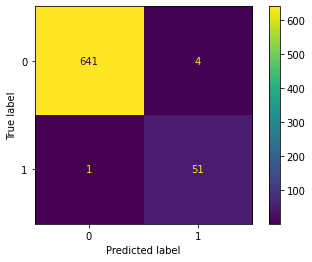

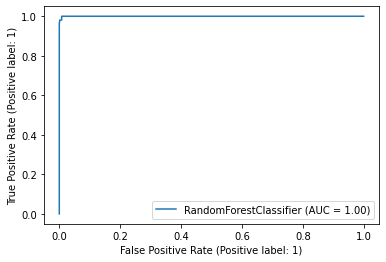

********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9670014347202296


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9578544061302682
the test recall for the class no is 0.9724770642201835
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9541984732824428
the test precision for the class no is 0.9747126436781609
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.97      0.97      0.97       436
         yes       0.95      0.96      0.96       261

    accuracy                           0.97       697
   macro avg       0.96      0.97      0.96  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


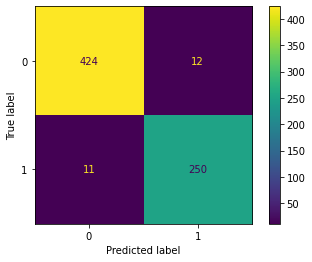

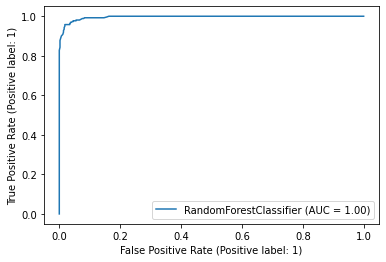

time: 2min 52s (started: 2022-05-13 16:24:14 +00:00)


In [13]:
#Address of the trained RL model 
Drive_model  ="/content/drive/MyDrive/Data/dqn-cartpole-50000-with127-GA-Mut-2.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)
#########################################################  Read DATA and Load Model #############

ep = []
buffer = []
line = 0
#Address of data of RL 
##changing the shape of the episodes when we are reading the data
file = "/content/drive/MyDrive/Data/dict_GA_Mut_10-09-2020.csv"
with open(file, 'r' ) as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        if row[0] == 'done':
          buffer.append([row[0],float(row[1])])
          ep.append(buffer)
          buffer = []
          line+=1
        else:
          ro = row[0][1:-1]
          r = [float(i) for i in ro.split()]
          buffer.append([r,row[1]])



######################################################### Read abstract classes #############
# /content/drive/MyDrive/GM/Abstract_unique1_for_d=1.pickle
# data of abstract classes

Read_from_data = True
d=1

if Read_from_data:
  with open(f'/content/drive/MyDrive/Data/Abstract_unique1_for_d=1.pickle', 'rb') as file2:
      unique1 = pickle.load(file2)
  uni1=np.array(unique1)
  unique5 = unique1
if not Read_from_data:
  unique1,uni1 = Abstract_classes(ep,d,model)
  unique5 = unique1


epsilon = 0.05
data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation(d,epsilon,uni1,model,ep,unique1)

#########################################################  Train ML -  Reward fault predictor  #############

X_train_reward_fault, X_test_reward_fault, y_train_reward_fault, y_test_reward_fault = train_test_split(data1_x_b, data1_y_b, test_size=0.33, random_state=42)

RF_RF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_RF_1rep.fit(X_train_reward_fault,y_train_reward_fault)
report(RF_RF_1rep,X_train_reward_fault,y_train_reward_fault,X_test_reward_fault,y_test_reward_fault)

#########################################################  Train ML - Functional fault predictor #############


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.33, random_state=42)
RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
RF_FF_1rep.fit(X_train_f,y_train_f)
report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)





#RQ1 - Functions

In [14]:
def randomtestsubsample_wo(population,sample_size):
  subSample= random.sample(population,sample_size)
  randrewardfault = []
  randfunctionalfault =[] 
  nonfaulty=[]
  epsilon = 0.05
  for ind_ in subSample:
    last_state = ind_.get_candidate_values()[-2]
    value_ = ind_.get_candidate_values()
    if fitness_reward(value_)<70:
      randrewardfault.append(ind_)
    if abs(last_state[0][0])>(2.4-epsilon):
      randfunctionalfault.append(ind_)
    if fitness_reward(value_)>70 and abs(last_state[0][0])<(2.4-epsilon):
      nonfaulty.append(ind_)
  return len(randfunctionalfault)

time: 8.22 ms (started: 2022-05-13 16:27:07 +00:00)


In [15]:
def change_threshold(new_threshold,results):
  return_set=[]
  for re_exe in results:
    episode = re_exe[3]
    ff_prob = episode.get_objective_values()[2]
    if ff_prob<=new_threshold:
      return_set.append(re_exe)
  return return_set


time: 4.38 ms (started: 2022-05-13 16:27:07 +00:00)


In [16]:
def get_stat(pff, path_to_reexe):
  items = os.listdir(path_to_reexe)
  stat =[] 
  for re_exe in items:
    final_consistent_ff = []
    with open(f'{path_to_reexe}/{re_exe}', 'rb') as file2:
        data = pickle.load(file2)
    new_data = change_threshold(pff,data)
    for result in new_data:
      inconsistent, div , ff, episode =result
      if ff:
        if not inconsistent:
          final_consistent_ff.append(result)
    stat.append([len(final_consistent_ff),len(new_data)])
  return stat

time: 8.97 ms (started: 2022-05-13 16:27:07 +00:00)


In [17]:
def prepair_random_data(stat, Mutation,initial_population_budget,iteration):
  data_size = [stats[1] for stats in stat]
  STARLA_stat = [stats[0] for stats in stat]
  AVG_data_size = int(sum(data_size)/len(data_size))
  comparision_size_scenario2 = AVG_data_size + Mutation + initial_population_budget
  comparision_size_scenario1 = AVG_data_size + Mutation 
  print("comparision_size_scenario1",comparision_size_scenario1)
  print("comparision_size_scenario2",comparision_size_scenario2)
  random_dist_scenario1 =[]
  random_dist_scenario2 =[]
  for i in range(iteration):
    # print("comparision_size_scenario1",comparision_size_scenario1)
    random_dist_scenario2.append(randomtestsubsample_wo(population_rand,comparision_size_scenario2))
  for i in range(iteration):
    # print("comparision_size_scenario2",comparision_size_scenario2)
    random_dist_scenario1.append(randomtestsubsample_wo(population_rand,comparision_size_scenario1))
  return [random_dist_scenario1,random_dist_scenario2,STARLA_stat]

time: 14.6 ms (started: 2022-05-13 16:27:07 +00:00)


In [18]:
with open(f'/content/drive/MyDrive/Data/random_test_Data_start_state.pickle', 'rb') as file2:
    rt_start_state = pickle.load(file2)
    
with open(f'/content/drive/MyDrive/GM/random_test_Data.pickle', 'rb') as file2:
    rt = pickle.load(file2)

population_rand = []
for i in range(len(rt)):
  cd = Candidate(rt[i])
  cd.set_start_state(rt_start_state[i])
  population_rand.append(cd)

"""
with this commented code below you can create random test for comparision but
it is time consuming and you need to make sure you have enough episodes for 
comparision; suggested minimum size of the the created episodes is 10k
use the saved data of 40k random episodes
"""


# ee,qq=random_test_2(model,env2,1_500_000)  #create initial population with random test
# test, teststate = fix_testing(ee,qq,env2)
# print('len population',len(test))
# population = []
# for i in range(len(test)):
#   cd = Candidate(test[i])
#   cd.set_start_state(teststate[i])
#   population.append(cd)

'\nwith this commented code below you can create random test for comparision but\nit is time consuming and you need to make sure you have enough episodes for \ncomparision; suggested minimum size of the the created episodes is 10k\nuse the saved data of 40k random episodes\n'

time: 1min 8s (started: 2022-05-13 16:27:07 +00:00)


In [19]:
def prepair_random_data_with_initial_pop(stat, Mutation,initial_population_budget,iteration,avg_initial_faulty,population_random_data):
  data_size = [stats[1] for stats in stat]
  STARLA_stat = [stats[0] for stats in stat]
  STARLA_stat_scenario2 = [stats[0]+avg_initial_faulty for stats in stat]
  AVG_data_size = int(sum(data_size)/len(data_size))
  comparision_size_scenario2 = AVG_data_size + Mutation + initial_population_budget
  comparision_size_scenario1 = AVG_data_size + Mutation 
  print("comparision_size_scenario1",comparision_size_scenario1)
  print("comparision_size_scenario2",comparision_size_scenario2)
  random_dist_scenario1 =[]
  random_dist_scenario2 =[]
  for i in range(iteration):
    random_dist_scenario2.append(randomtestsubsample_wo(population_random_data,comparision_size_scenario2))
  for i in range(iteration):
    random_dist_scenario1.append(randomtestsubsample_wo(population_random_data,comparision_size_scenario1))
  return [random_dist_scenario1,random_dist_scenario2,STARLA_stat,STARLA_stat_scenario2]

time: 11.1 ms (started: 2022-05-13 16:28:16 +00:00)


In [20]:
def Build_Archive(pop,no_of_Objectives,threshold_criteria, stored_data, initial_population):
  '''
  If you are using the Archive of all generated episodes, this function
  removes the duplicated results and builds the Archive.
  :param 'pop': current generation
  :param 'no_of_Objectives': number of objectives
  :param 'threshold_criteria': threshold criteria (we are intrested in episodes that have fitness below these threshold values)
  :param 'stored_data': Archive of final episodes (return)
  :param 'initial_population': initial population. we are not considering these episodes in our archive for the second senario you need to add the number of faults, (implementation in RQ3)
  '''
  threshold_criteria_to_add_to_archive = threshold_criteria
# be careful as we can have different values for criterias here to add episodes to archive and for GA stopping criteria 
  for individual in pop:
    individual_objective = individual.get_objective_values()
    for i in range(no_of_Objectives):
      if individual_objective[i]<threshold_criteria_to_add_to_archive[i]:
        found = False
        for j in range(len(stored_data)):
          if individual_objective == stored_data[j].get_objective_values():
            found = True
            break
        for k in range(len(initial_population)):
          if individual_objective == initial_population[k].get_objective_values():
            found = True
            break
        if not found:
          ind_ = deepcopy(individual)
          stored_data.append(ind_)

time: 10.5 ms (started: 2022-05-13 16:28:16 +00:00)


#Run RQ1 - Functional fault

In [ ]:
# extract the average of number of mutations
with open(f'/content/drive/MyDrive/Data/mutation_numbers.pickle', 'rb') as file2:
    Mutation_numbers = pickle.load(file2)

Mutations = int(sum(Mutation_numbers)/len(Mutation_numbers))

Mutation = Mutations   #number of the mutations performed during the search. it is stores in a seperate file  in our experiment avg=130
initial_population_budget = 1500  
iteration = 100  # number of the random subsamples 

###  read data and extract the number of functional faults 

items = os.listdir('/content/drive/MyDrive/Data/Results')
thresholds = [70, 0.04, 0.50, 0.50]
initial_pop_faults=[]
for generations in items:
  Functional_Fault_counter = 0
  Reward_Fault_counter = 0
  if generations=='res' or generations=='.ipynb_checkpoints':
    continue
  with open(f'/content/drive/MyDrive/Data/Results/{generations}', 'rb') as file2:
      data = pickle.load(file2)
  functionalfault=[]
  for i in range(len(data)):
    if i == 0:
      initial_pop = data[i]
      for ind_ in initial_pop:
        value_ = ind_.get_candidate_values()
        last_state = ind_.get_candidate_values()[-2]
        if abs(last_state[0][0])>(2.4-epsilon):
          Functional_Fault_counter+=1
  initial_pop_faults.append(Functional_Fault_counter)

time: 3min 32s (started: 2022-05-11 21:01:53 +00:00)


comparision_size_scenario1 5512
comparision_size_scenario2 7012


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


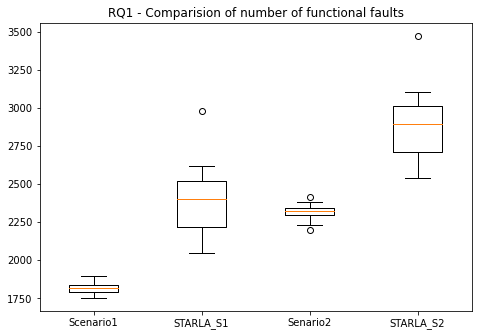

time: 1min 41s (started: 2022-05-11 23:04:03 +00:00)


In [ ]:
ff_probability = 0.5   #threshold of the probability of the functional fault select 50% ->0.5 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()


In [ ]:
for i in range(len(plot_data)):
  print('Median of boxplot',i,'is:',statistics.median(plot_data[i]))

Median of boxplot 0 is: 1819.5
Median of boxplot 1 is: 2315.0
Median of boxplot 2 is: 2402.0
Median of boxplot 3 is: 2892.0
time: 3.06 ms (started: 2022-05-11 22:31:25 +00:00)


#Run RQ1 - Reward fault 

In [ ]:
items = os.listdir('/content/drive/MyDrive/GM/execution4_gen')
thresholds = [70, 0.04, 0.50, 0.50]
reward_faults=[]
for generations in items:
  Reward_Fault_counter = 0
  arch2=[]
  if generations=='res' or generations=='.ipynb_checkpoints':
    continue
  with open(f'/content/drive/MyDrive/GM/execution4_gen/{generations}', 'rb') as file2:
      data = pickle.load(file2)
  for i in range(len(data)):
    if i == 0:
      continue
    Build_Archive(data[i],4,thresholds,arch2,initial_pop)
  for epis in arch2:
    objectives_ = epis.get_objective_values()
    if objectives_[0]<thresholds[0]:
      Reward_Fault_counter+=1
    
  reward_faults.append(Reward_Fault_counter)

time: 15min 27s (started: 2022-05-11 21:33:55 +00:00)


In [ ]:
reward_faults

[133, 87, 100, 56, 104, 110, 94, 98, 97, 110, 82, 114, 85, 139]

time: 5.12 ms (started: 2022-05-11 21:49:23 +00:00)


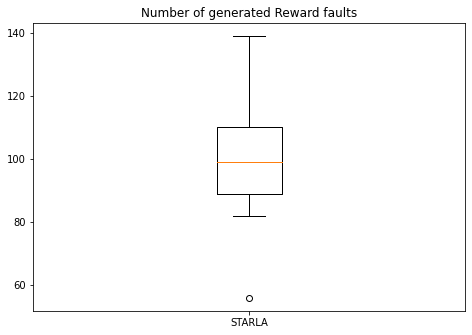

time: 216 ms (started: 2022-05-11 23:03:22 +00:00)


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(reward_faults)
plt.xticks([1], ["STARLA"])
plt.title('Number of generated Reward faults')
plt.show()

In [ ]:
statistics.median(reward_faults)

99.0

time: 4.68 ms (started: 2022-05-11 21:49:24 +00:00)


#Mann-Whitney Test

In [ ]:
from scipy.stats import mannwhitneyu

# Carrying out the Wilcoxon–Mann–Whitney test
results = mannwhitneyu(plot_data[0], plot_data[2])
print("The result of Mann–Whitney test, Scenario 1 : ", results)

The result of Mann–Whitney test, Scenario 1 :  MannwhitneyuResult(statistic=0.0, pvalue=7.729892009699568e-10)
time: 6.26 ms (started: 2022-05-11 22:33:04 +00:00)


In [ ]:
results2 = mannwhitneyu(plot_data[1], plot_data[3])
print("The result of Mann–Whitney test, Scenario 1 : ", results2)


The result of Mann–Whitney test, Scenario 1 :  MannwhitneyuResult(statistic=0.0, pvalue=7.722863341747964e-10)
time: 6.18 ms (started: 2022-05-11 22:33:05 +00:00)


#Similarities

In [ ]:
def change_threshold_in_similarity_data(new_threshold,results):
  return_set=[]
  for re_exe in results:
    episode = re_exe[4]
    ff_prob = episode.get_objective_values()[2]
    if ff_prob<=new_threshold:
      return_set.append(re_exe)
  return return_set


time: 3.32 ms (started: 2022-05-11 22:36:23 +00:00)


In [ ]:
from scipy.spatial.distance import cosine,euclidean
items = os.listdir('/content/drive/MyDrive/GM/res/re_executed_Similarity')
stat =[] 
cc=[]
pff = 0.5

for re_exe in items[:]:
  CosineDistance=[]
  EuaclidianDistance=[]
  final_consistent_ff = []
  # print("\n\n-----------------------------------------------------\n\n")
  print(f'/content/drive/MyDrive/GM/res/re_executed_Similarity/{re_exe}')
  with open(f'/content/drive/MyDrive/GM/res/re_executed_Similarity/{re_exe}', 'rb') as file2:
      data = pickle.load(file2)
  new_data = change_threshold_in_similarity_data(pff,data)
  for result in new_data:
    inconsistent, div , ff, states, episode =result
    if ff:
      if not inconsistent:
        final_consistent_ff.append(result)
        for st in states:
          if cosine(st[0],st[1])>1.2:
            break
          CosineDistance.append(cosine(st[0],st[1]))
          EuaclidianDistance.append(euclidean(st[0],st[1]))
        for div_item in div:
          cc.append(abs(div_item[1][0]-div_item[1][1]))
  stat.append([CosineDistance,EuaclidianDistance])


/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_2.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_3.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run0_4.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_1.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_7.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_8.pickle
/content/drive/MyDrive/GM/res/re_executed_Similarity/re_executedCopy of March018_generations_r110_rt70_population1500lastfull_run1_5.pickle
/content/drive/MyDri

Text(0.5, 1.0, 'Cosine distance of one run')

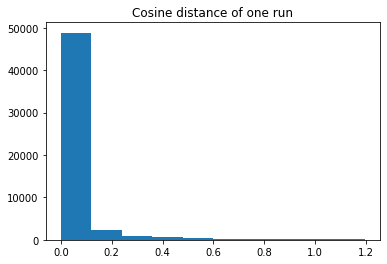

time: 404 ms (started: 2022-05-11 23:06:14 +00:00)


In [ ]:
plt.hist(CosineDistance)
plt.title('Cosine distance of one run')

Text(0.5, 1.0, 'Euclidian distance of one run')

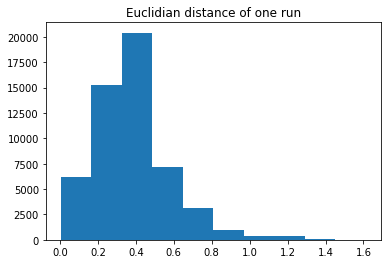

time: 448 ms (started: 2022-05-11 23:06:31 +00:00)


In [ ]:
plt.hist(EuaclidianDistance)
plt.title('Euclidian distance of one run')

Text(0.5, 1.0, 'comparision')

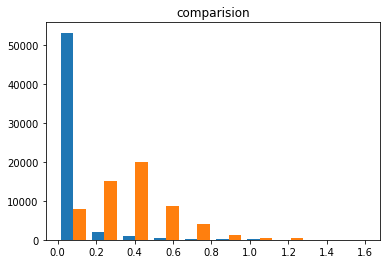

time: 645 ms (started: 2022-05-11 23:06:46 +00:00)


In [ ]:
plt.hist(stat[1])
plt.title('comparision')

In [ ]:
cosine_distances = [item[0] for item in stat]
euclidian_distances = [item[1] for item in stat]


time: 14.5 ms (started: 2022-05-11 22:59:49 +00:00)


In [ ]:
flatten_cosine_distances = [value for sublist in cosine_distances for value in sublist]
flatten_euclidian_distances = [value for sublist in euclidian_distances for value in sublist]

time: 253 ms (started: 2022-05-11 22:59:50 +00:00)


Text(0.5, 1.0, 'Cosine distances of replaced states in all runs of STARLA')

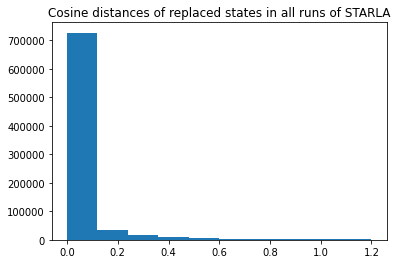

time: 1.01 s (started: 2022-05-11 23:07:26 +00:00)


In [ ]:
plt.hist(flatten_cosine_distances)
plt.title('Cosine distances of replaced states in all runs of STARLA')

Text(0.5, 1.0, 'Euclidian distances of replaced states in all runs of STARLA')

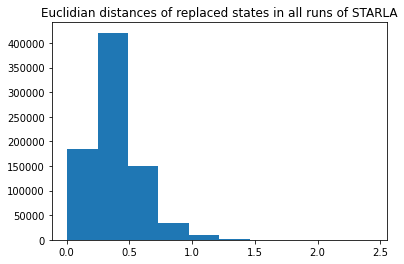

time: 909 ms (started: 2022-05-11 23:07:40 +00:00)


In [ ]:
plt.hist(flatten_euclidian_distances)
plt.title('Euclidian distances of replaced states in all runs of STARLA')


In [ ]:
count = 0 

for i in flatten_cosine_distances:
  if i<0.25:
    count+=1

print("More than ",count/len(flatten_cosine_distances),"% of replaced states have a cosine distance below 0.25")

More than  0.9509584369413903 % of replaced states have a cosine distance below 0.25
time: 575 ms (started: 2022-05-11 23:01:46 +00:00)


Text(0.5, 1.0, 'Confidence level - all runs of STARLA')

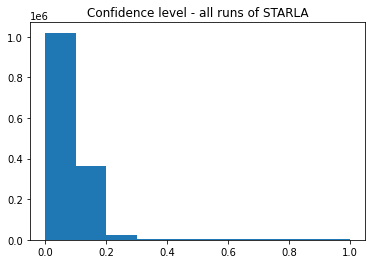

time: 1.03 s (started: 2022-05-11 23:08:31 +00:00)


In [ ]:
plt.hist(cc)
plt.title('Confidence level - all runs of STARLA')


#RQ1 - Functional fault - Analysis of different thresholds of probabilities of functional faults

In [21]:
# extract the average of number of mutations
with open(f'/content/drive/MyDrive/Data/mutation_numbers.pickle', 'rb') as file2:
    Mutation_numbers = pickle.load(file2)

Mutations = int(sum(Mutation_numbers)/len(Mutation_numbers))

Mutation = Mutations   #number of the mutations performed during the search. it is stores in a seperate file  in our experiment avg=130
initial_population_budget = 1500  
iteration = 100  # number of the random subsamples 

###  read data and extract the number of functional faults 

items = os.listdir('/content/drive/MyDrive/Data/Results')
thresholds = [70, 0.04, 0.50, 0.50]
initial_pop_faults=[]
for generations in items:
  Functional_Fault_counter = 0
  Reward_Fault_counter = 0
  if generations=='res' or generations=='.ipynb_checkpoints':
    continue
  with open(f'/content/drive/MyDrive/Data/Results/{generations}', 'rb') as file2:
      data = pickle.load(file2)
  functionalfault=[]
  for i in range(len(data)):
    if i == 0:
      initial_pop = data[i]
      for ind_ in initial_pop:
        value_ = ind_.get_candidate_values()
        last_state = ind_.get_candidate_values()[-2]
        if abs(last_state[0][0])>(2.4-epsilon):
          Functional_Fault_counter+=1
  initial_pop_faults.append(Functional_Fault_counter)

time: 3min 49s (started: 2022-05-13 16:29:17 +00:00)


comparision_size_scenario1 5321
comparision_size_scenario2 6821


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


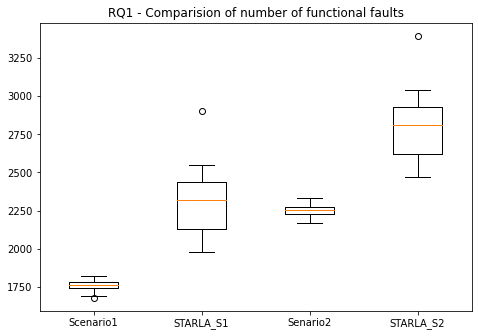

time: 2min 14s (started: 2022-05-13 17:40:40 +00:00)


In [22]:
ff_probability = 0.45   #threshold of the probability of the functional fault select 55% ->0.45 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 5065
comparision_size_scenario2 6565


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


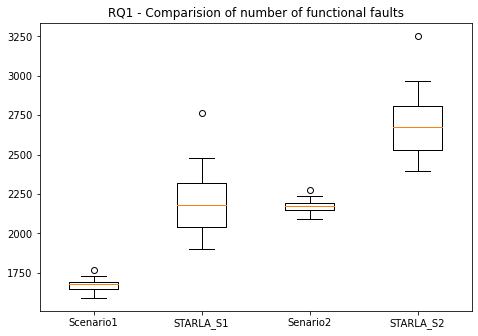

time: 2min 15s (started: 2022-05-13 17:43:05 +00:00)


In [23]:
ff_probability = 0.40   #threshold of the probability of the functional fault select 60% ->0.4 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 4766
comparision_size_scenario2 6266


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


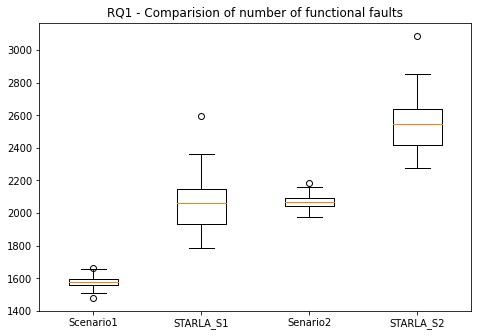

time: 1min 51s (started: 2022-05-13 17:45:20 +00:00)


In [24]:
ff_probability = 0.35   #threshold of the probability of the functional fault select 65% ->0.35 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 4411
comparision_size_scenario2 5911


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


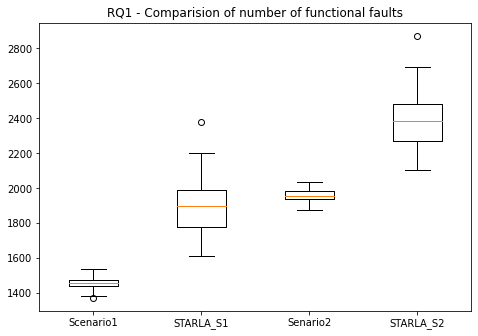

time: 1min 29s (started: 2022-05-13 17:47:12 +00:00)


In [25]:
ff_probability = 0.30   #threshold of the probability of the functional fault select 70% ->0.3 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 3922
comparision_size_scenario2 5422


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


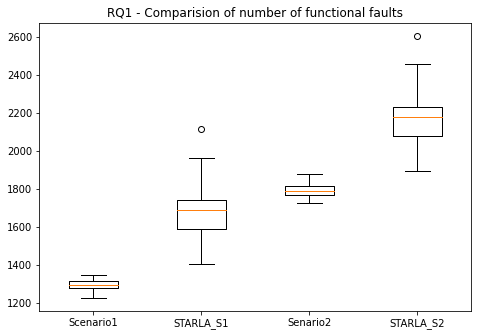

time: 1min 26s (started: 2022-05-13 17:48:42 +00:00)


In [26]:
ff_probability = 0.25   #threshold of the probability of the functional fault select 75% ->0.25 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 3292
comparision_size_scenario2 4792


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


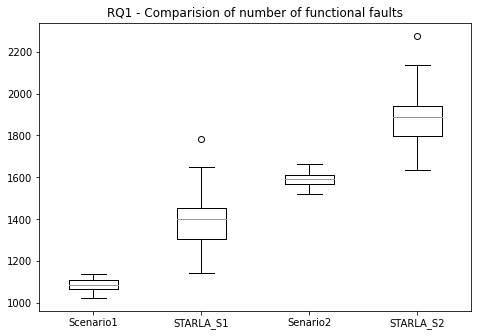

time: 1min 32s (started: 2022-05-13 17:50:08 +00:00)


In [27]:
ff_probability = 0.20   #threshold of the probability of the functional fault select 80% ->0.20 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 2439
comparision_size_scenario2 3939


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


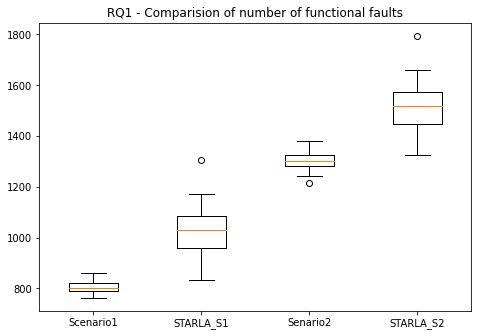

time: 1min 33s (started: 2022-05-13 17:51:41 +00:00)


In [28]:
ff_probability = 0.15   #threshold of the probability of the functional fault select 85% ->0.15 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 1424
comparision_size_scenario2 2924


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


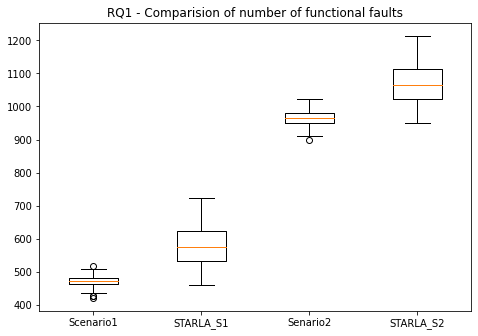

time: 1min 28s (started: 2022-05-13 17:53:14 +00:00)


In [29]:
ff_probability = 0.10   #threshold of the probability of the functional fault select 90% ->0.10 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()

comparision_size_scenario1 538
comparision_size_scenario2 2038


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


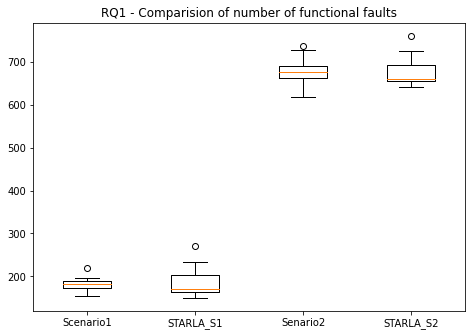

time: 1min 21s (started: 2022-05-13 17:54:42 +00:00)


In [30]:
ff_probability = 0.05   #threshold of the probability of the functional fault select 95% ->0.05 this is the inverse of probabilities 0.1 is 90%
init_faulty_avg = int(sum(initial_pop_faults)/len(initial_pop_faults))
path_to_files = '/content/drive/MyDrive/Data/Executions'


plot_data = prepair_random_data_with_initial_pop(get_stat(ff_probability,path_to_files),
                                                 Mutation,initial_population_budget,
                                                 iteration,init_faulty_avg,population_rand)
re_arrange = [plot_data[0],plot_data[2],plot_data[1],plot_data[3]]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(re_arrange)
plt.xticks([1, 2, 3, 4], ["Scenario1","STARLA_S1","Senario2","STARLA_S2"])
plt.title('RQ1 - Comparision of number of functional faults')
plt.show()